# TRANSFORMERS_PREDICTION

Yuu Ricardo Akachi Tanaka
A01351969

# Time series forecasting with Transformer model

Once again, we'll work with the weather time series dataset collected at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Keep in mind that dataset includes 14 different variables such as air temperature, air pressure, humidity, wind direction and others, recorded every 10 minutes over several years. While the original data go back to 2003, our focus here is on the data from 2009 to 2016. Our goal is to construct a model that takes recent historical data (a few days' worth of data points) as input and predicts the air temperature 24 hours into the future.

You can obtain and decompress the data using the following instructions:

In [2]:
%%bash
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

--2025-04-18 04:12:48--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.254.8, 52.217.103.14, 52.216.212.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.254.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

     0K .......... .......... .......... .......... ..........  0%  858K 15s
    50K .......... .......... .......... .......... ..........  0%  905K 15s
   100K .......... .......... .......... .......... ..........  1% 52.4M 10s
   150K .......... .......... .......... .......... ..........  1%  909K 11s
   200K .......... .......... .......... .......... ..........  1% 99.0M 9s
   250K .......... .......... .......... .......... ..........  2%  100M 7s
   300K .......... .......... .......... .......... ..........  2%  108M 6s
   350K .......... .......... .......... .......... ...

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


By the way, the following code is a modified version of the code that can be found in [1]. That said, let us begin by importing some useful libraries and modules.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

The following lines of code will open the `csv` file that was downloaded and store that information in the variable named `data`.

In [4]:
data_dir = 'jena_climate'
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


We can see that we're working with 14 variables and 420,551 registers. In the following cell, we'll create two `NumPy` arrays: one for the temperature variable (`temperature`), and another one for all the data (`raw_data`).  

En el caso del transformer, únicamente se estará utilizando la variable de temperatura para hacer la predicción de la temperatura a futuro.

In [5]:
temperature = np.zeros((len(lines),))
# raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    #raw_data[i, :] = values[:]

# reshape para que funcione con timeseries_dataset_from_array
raw_data = temperature.reshape(-1, 1) # temperature es la única variable independiente

Here is the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature.

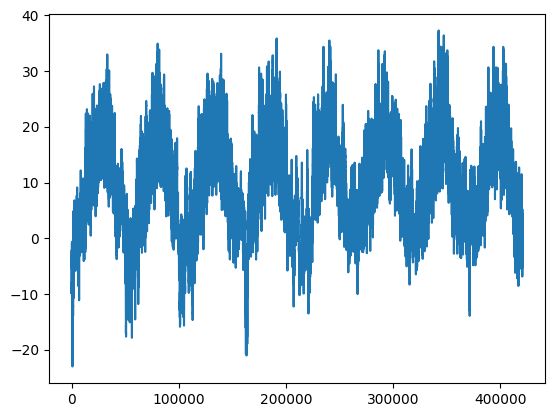

In [6]:
plt.plot(range(len(temperature)), temperature)

By the way, it is recommended that you always look for periodicity in your data. Time series data usually have periodicity on different time scales, so it's important to find these patterns so that the models we train can learn them.

In the next steps we'll allocate 50% of the data to training, 25% to validation and the remainder to testing. When dealing with time series data, it's important to ensure that the validation and test data sets are more recent than the training data. This is because our goal is to predict the future based on past observations, not to predict the past based on the future.

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Formulation of the problem

The problem we will be solving goes as follows: given data going as far back as `sequence_length` timesteps (a timestep is 10 minutes) and sampled every `sampling_rate` timesteps, can we predict the temperature in `delay` timesteps? We will use the following parameter values:

- `sequence_length`: 120—Observations will go back 5 days.
- `sampling_rate`: 6—Observations will be sampled at one data point per hour.
- `delay`: Targets will be 24 hours after the end of the sequence.

## Preparing the data

Each time series in the dataset operates on a different scale: for example, temperature typically ranges between -20 and +30, whereas atmospheric pressure, measured in mbar, hovers around 1,000. To deal with this, we'll normalize each time series independently, ensuring that they all have small values within a comparable scale.

En este caso ya no es necesario normalizar ya que únicamente se está utilizando la varible de temperatura

In [ ]:
#mean = raw_data[: num_train_samples].mean(axis=0)
#raw_data -= mean
#std = raw_data[: num_train_samples].std(axis=0)
#raw_data /= std

Next, we'll construct a `dataset` object that produces batches of data over the past five days, along with a target temperature for 24 hours into the future.

As before, we could write a `Python` generator to do this, however, `Keras`  provides a handy built-in dataset utility (`timeseries_dataset_from_array()`). As expected, we'll use this utility to instantiate three datasets: one fore training, onf for validation, and one for testing.

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2025-04-19 22:36:02.644394: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Every dataset provides a tuple (`samples`, `targets`), where samples represent a batch of 256 samples. Each `sample` comprises 120 consecutive hours of input data, while `targets` consist of the corresponding array of 256 target temperatures. It's important to note that the samples are shuffled randomly, meaning that two consecutive sequences in a batch (such as `samples[0]` and `samples[1]`) may not be temporally adjacent.

## A common-sense baseline

In this scenario, we can reasonably assume that the temperature timeseries is continuous (tomorrow's temperatures are expected to be similar to today's) and periodic, with a daily cycle. Therefore, a straightforward approach is to predict that the temperature 24 hours from now will be the same as the current temperature. We'll assess this method using the mean absolute error (MAE) metric.

In [9]:
def evaluate_naive_method(dataset):

    total_abs_err = 0.
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1, 0] # * std[0] + mean[0] ya no es necesario porque no normalicé # como ahora solo tengo temperatura, es el índice 0
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-04-19 22:36:11.992380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


2025-04-19 22:36:18.919722: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This simple baseline results in a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. Therefore, predicting that the temperature 24 hours ahead will be identical to the current temperature leads to an average error of around two and a half degrees. This said, we'd expect our models to do better than this.  

## Transformer model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    attention = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed Forward Part
    ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff)
    out = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return out


In [11]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(input_shape))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x) # modifiqué esto para que fuera una sola salida porque es regresión
    return keras.Model(inputs, outputs)

In [12]:
(sequence_length, raw_data.shape[1])

(120, 1)

In [13]:
input_shape = (sequence_length, raw_data.shape[1]) # modifiqué esto para meter en el modelo (pasos en el tiempo, 1 variable temperatura)

model = build_model(
    input_shape = input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.1,
    dropout=0.25,
)

model.compile(
    loss="mse",
    optimizer='rmsprop',
    metrics=["mae"],
)

model.summary()

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

history = model.fit(
          train_dataset,
          validation_data=val_dataset,
          epochs=5, # 5 épocas porque tarda mucho
          callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 1)    │      1,793 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 120, 1)    │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 120, 1)    │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 120, 128)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 128)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 120, 1)    │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 1)    │      1,793 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 120, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 120, 128)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 120, 128)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 1)    │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 120, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 1)    │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,557 (17.80 KB)

 Trainable params: 4,557 (17.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2025-04-19 22:36:23.193742: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2025-04-19 22:36:23.194073: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2025-04-19 22:36:23.194145: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2025-04-19 22:36:23.331213: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2025-04-19 22:36:23.331807: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.


819/819 ━━━━━━━━━━━━━━━━━━━━ 623s 755ms/step - loss: 151.4823 - mae: 10.2000 - val_loss: 147.5957 - val_mae: 10.0682
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 598s 730ms/step - loss: 138.0443 - mae: 9.6787 - val_loss: 133.3773 - val_mae: 9.5116
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 596s 727ms/step - loss: 125.9151 - mae: 9.1962 - val_loss: 120.5007 - val_mae: 8.9996
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 599s 732ms/step - loss: 115.0765 - mae: 8.7538 - val_loss: 108.9631 - val_mae: 8.5377
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 601s 733ms/step - loss: 105.6579 - mae: 8.3636 - val_loss: 98.7696 - val_mae: 8.1185
405/405 ━━━━━━━━━━━━━━━━━━━━ 103s 253ms/step - loss: 103.3786 - mae: 7.9958
Test MAE: 7.99


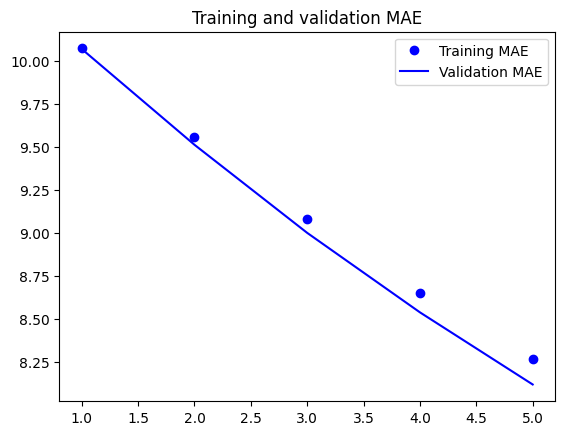

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

La validación MAE bajó aproximadamente hasta 8 grados Celcius. No es tan bueno el modelo, sin embargo, si ponemos más épocas podría mejorar. En este caso no se hizo porque cada época tardaba mucho.

* Esto es extra, fue para checar resultados

In [15]:
predictions = model.predict(test_dataset)
predictions

405/405 ━━━━━━━━━━━━━━━━━━━━ 88s 216ms/step


array([[4.0846953],
       [4.0846953],
       [4.0846953],
       ...,
       [4.0846953],
       [4.0846953],
       [4.0846953]], dtype=float32)

In [16]:
y_true = []
for _, targets in test_dataset:
    y_true.extend(targets.numpy())  # convertir a lista de valores

y_true = np.array(y_true)


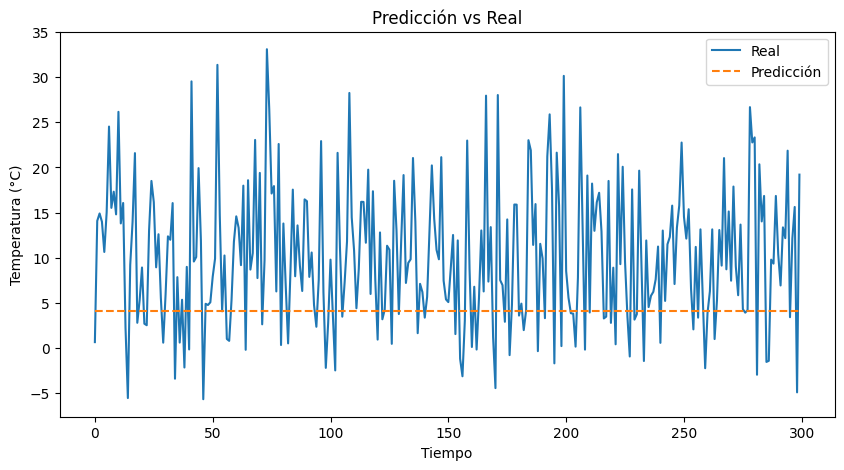

In [ ]:
# Gráfica de los primeros 300
plt.figure(figsize=(10, 5))
plt.plot(y_true[:300], label="Real")
plt.plot(predictions[:300], label="Predicción", linestyle='dashed')
plt.legend()
plt.title("Predicción vs Real")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")
plt.show()

El modelo predice un mismo valor para todos los casos, intenta sacar la media. No es lo ideal pero funciona.

## References

[1] Chollet, Francois. *Deep learning with Python*. Simon and Schuster, 2021.